In [1]:
import cv2
import h5py
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import pickle
import shutil

from tqdm import tqdm

In [2]:
from tactile_learning.datasets import dump_video_to_images, get_closest_id
from tactile_learning.utils import plot_tactile_sensor

In [3]:
class XelaCurvedPlotter():
    def __init__(self, display_plot=True):
        if not display_plot:
            matplotlib.use('Agg')

        thumb = [['thumb_empty'],
          ['thumb_tip'],
          ['thumb_section2'],
          ['thumb_section3']]

        index = [['index_tip'],
                ['index_section1'],
                ['index_section2'],
                ['index_section3']]

        ring = [['ring_tip'],
                ['ring_section1'],
                ['ring_section2'],
                ['ring_section3']]

        middle = [['mid_tip'],
                ['mid_section1'],
                ['mid_section2'],
                ['mid_section3']]

        all_fingers = [thumb, index, middle, ring]

        hand = [[thumb, index, middle, ring],
                ['palm', 'palm', 'palm', 'palm']]
        
        fig, self.axs = plt.subplot_mosaic(hand, figsize=(10,20))

    def _set_limits(self):
        pass

    def plot_tactile_sensor(self,ax, sensor_values, use_img=False, img=None, title='Tip Position'):
    # sensor_values: (16, 3) - 3 values for each tactile - x and y represents the position, z represents the pressure on the tactile point
        img_shape = (240, 240, 3) # For one sensor
        blank_image = np.ones(img_shape, np.uint8) * 255
        if use_img == False: 
            img = ax.imshow(blank_image.copy())
        ax.set_title(title)

        # Set the coordinates for each circle
        tactile_coordinates = []
        for j in range(60, 180+1, 40): # Y
            for i in range(60, 180+1, 40): # X - It goes from top left to bottom right row first 
                tactile_coordinates.append([i,j])

        # Plot the circles 
        for i in range(sensor_values.shape[0]):
            center_coordinates = (
                tactile_coordinates[i][0] + int(sensor_values[i,0]/20), # NOTE: Change this
                tactile_coordinates[i][1] + int(sensor_values[i,1]/20)
            )
            radius = max(10 + int(sensor_values[i,2]/10), 2)
        
            if i == 0:
                frame_axis = cv2.circle(blank_image.copy(), center_coordinates, radius, color=(0,255,0), thickness=-1)
            else:
                frame_axis = cv2.circle(frame_axis.copy(), center_coordinates, radius, color=(0,255,0), thickness=-1)

        img.set_array(frame_axis)

        return img, frame_axis

    def plot_tactile_curved_tip(self,ax, sensor_values, use_img=False, img=None, title='Tip Position'):
        # sensor_values: (16, 3) - 3 values for each tactile - x and y represents the position, z represents the pressure on the tactile point
        img_shape = (240, 240, 3) # For one sensor
        blank_image = np.ones(img_shape, np.uint8) * 255
        if use_img == False: 
            img = ax.imshow(blank_image.copy())
        ax.set_title(title)

        # Set the coordinates for each circle
        tactile_coordinates = []
        for j in range(20, 240, 40): # y axis
            # x axis is somewhat hard coded
            for i in range(20, 240, 40):
                if j == 20 and (i == 100 or i == 140): # Only the middle two will be added
                    tactile_coordinates.append([i,j])
                elif (j > 20 and j < 100) and (i > 20 and i < 220):
                    tactile_coordinates.append([i,j])
                elif j >= 100: 
                    tactile_coordinates.append([i,j])
        
        # Plot the circles 
        for i in range(sensor_values.shape[0]):
            center_coordinates = (
                tactile_coordinates[i][0] + int(sensor_values[i,0]/20),
                tactile_coordinates[i][1] + int(sensor_values[i,1]/20)
            )
            radius = max(10 + int(sensor_values[i,2]/10), 2)
        
            if i == 0:
                frame_axis = cv2.circle(blank_image.copy(), center_coordinates, radius, color=(0,255,0), thickness=-1)
            else:
                frame_axis = cv2.circle(frame_axis.copy(), center_coordinates, radius, color=(0,255,0), thickness=-1)

        img.set_array(frame_axis)

        return img, frame_axis


    def plot_tactile_palm(self,ax, sensor_values, use_img=False, img=None, title='Tip Position'):
        # sensor_values: (16, 3) - 3 values for each tactile - x and y represents the position, z represents the pressure on the tactile point
        img_shape = (480, 960, 3) # For one sensor
        blank_image = np.ones(img_shape, np.uint8) * 255
        if use_img == False: 
            img = ax.imshow(blank_image.copy())
        ax.set_title(title)

        # Set the coordinates for each circle
        tactile_coordinates = []

        for j in range(70, 190+1, 40):
            for i in range(220, 420+1, 40):
                tactile_coordinates.append([i,j])

        for j in range(70, 190+1, 40):
            for i in range(540, 740+1, 40):
                tactile_coordinates.append([i,j])

        for j in range(270, 390+1, 40):
            for i in range(540, 740+1, 40):
                tactile_coordinates.append([i,j])

        # Plot the circles 
        for i in range(sensor_values.shape[0]):
            center_coordinates = (
                tactile_coordinates[i][0] + int(sensor_values[i,0]/20),
                tactile_coordinates[i][1] + int(sensor_values[i,1]/20)
            )
            radius = max(10 + int(sensor_values[i,2]/10), 2)
        
            if i == 0:
                frame_axis = cv2.circle(blank_image.copy(), center_coordinates, radius, color=(0,255,0), thickness=-1)
            else:
                frame_axis = cv2.circle(frame_axis.copy(), center_coordinates, radius, color=(0,255,0), thickness=-1)

        img.set_array(frame_axis)

        return img, frame_axis

    def draw(self, palm_sensor_values, fingertip_sensor_values, finger_sensor_values, figure_plot_path):
        cnt_fingertip=0
        cnt_finger=0
        for k in self.axs:
            if 'tip' in k:
                self.fingertip_sensor_values=fingertip_sensor_values
                self.plot_tactile_curved_tip(self.axs[k], sensor_values=self.fingertip_sensor_values[cnt_fingertip], title=k)
                cnt_fingertip+=1
            elif 'palm' in k:
                palm_sensor_values = np.concatenate(palm_sensor_values, axis=0)
                assert palm_sensor_values.shape == (72,3), f'palm_sensor_values.shape: {palm_sensor_values.shape}'
                self.plot_tactile_palm(self.axs[k], sensor_values = palm_sensor_values, title=k)
            elif not 'empty' in k:
                self.finger_sensor_values= finger_sensor_values
                self.plot_tactile_sensor(self.axs[k], sensor_values=self.finger_sensor_values[cnt_finger], title=k)
                cnt_finger+=1
            self.axs[k].get_yaxis().set_ticks([])
            self.axs[k].get_xaxis().set_ticks([])

        plt.savefig(figure_plot_path)

        # Resetting and pausing the plot
        plt.pause(0.01)
        plt.cla()

In [4]:
import decimal

def get_closest_id(curr_id, desired_timestamp, all_timestamps):
    for i in range(curr_id, len(all_timestamps)):
        if all_timestamps[i] >= desired_timestamp:
            return i # Find the first timestamp that is after that
    
    return i

# Get the metadata of images and tactile information
def get_desired_indices(root, fps, view_num=0): # frames per second from the video to receive
    image_metadata_path = os.path.join(root, f'cam_{view_num}_rgb_video.metadata')
    tactile_info_path = os.path.join(root, 'touch_sensor_values.h5')

    with open(image_metadata_path, 'rb') as f:
        image_metadata = pickle.load(f)
        image_timestamps_array = np.asarray(image_metadata['timestamps'])
        image_timestamps = np.asarray(image_metadata['timestamps']) / 1000.
    with h5py.File(tactile_info_path, 'r') as f:
        tactile_timestamps = f['timestamps'][()]

    image_id, tactile_id = 0, 0
    curr_timestamp = tactile_timestamps[0] # These timestamps are in seconds
    image_id = get_closest_id(image_id, curr_timestamp, image_timestamps)

    tactile_indices, image_indices = [], []
    tactile_indices.append(tactile_id)
    image_indices.append(image_id)

    frame_period = 1. / fps
    while(True):
        curr_timestamp += frame_period
        tactile_id = get_closest_id(tactile_id, curr_timestamp, tactile_timestamps)
        image_id = get_closest_id(image_id, curr_timestamp, image_timestamps)

        if curr_timestamp > tactile_timestamps[tactile_id] and curr_timestamp > image_timestamps[image_id]:
            break

        tactile_indices.append(tactile_id)
        image_indices.append(image_id)

    assert len(tactile_indices) == len(image_indices)
    return tactile_indices, image_indices


In [5]:

def dump_states(root, tactile_indices, image_indices, view_num=0):
    # Make directory to dump the visualization
    pbar = tqdm(total=len(tactile_indices))

    with h5py.File(os.path.join(root, 'touch_sensor_values.h5'), 'r') as f:
        all_tactile_values = f['sensor_values'][()]

    viz_dir = os.path.join(root, 'visualization')
    os.makedirs(viz_dir, exist_ok=True)
    
    video_path = os.path.join(root, f'cam_{view_num}_rgb_video.avi')
    vidcap = cv2.VideoCapture(video_path)
    success, image = vidcap.read()
    frame_count = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_id = 0
    for i in range(len(tactile_indices)):
        tactile_id, image_id = tactile_indices[i], image_indices[i]
        while frame_id != image_id and success:
            # Find the frame that is equal to image_id
            success, image = vidcap.read()
            frame_id += 1
        dump_demo_state(
            frame_id = i,
            viz_dir = viz_dir,
            tactile_values = all_tactile_values[tactile_id,:,:,:],
            camera_img = image
        )

        pbar.update(1)

    pbar.close()

def dump_demo_state(frame_id, viz_dir, tactile_values, camera_img):
    # tactile_values: (15,16,3)
    fig, axs = plt.subplots(figsize=(20,20), nrows=4, ncols=4)
    for row_id in range(4):
        for column_id in range(4):
            if row_id + column_id > 0: # The top left axis should stay empty
                plot_tactile_sensor(
                    ax = axs[column_id][row_id],
                    sensor_values = tactile_values[row_id*4 + column_id-1],
                    title = f'Sensor {row_id*4+column_id-1}'
                )
    fig.suptitle('Tactile State')
    fig.savefig(os.path.join(viz_dir, 'Tactile State.png'))
    fig.clf()
    plt.close()

    tactile_img = cv2.imread(os.path.join(viz_dir, 'Tactile State.png'))
    height_scale = camera_img.shape[0] / tactile_img.shape[0]
    tactile_img = cv2.resize(
        tactile_img,
        (int(tactile_img.shape[1] * height_scale),
         int(tactile_img.shape[0] * height_scale))
    )
    total_img = cv2.hconcat([camera_img, tactile_img])

    img_name = 'state_{}.png'.format(str(frame_id).zfill(3))
    cv2.imwrite(os.path.join(viz_dir, img_name), total_img)



In [6]:

def dump_states_curved_fingertip(root, tactile_indices, image_indices, view_num=0):
    # Make directory to dump the visualization
    pbar = tqdm(total=len(tactile_indices))

    with h5py.File(tactile_info_path, 'r') as f:
        all_finger_sensor_values = f['finger_sensor_values'][()]
        all_fingertip_sensor_values = f['fingertip_sensor_values'][()]
        all_palm_sensor_values = f['palm_sensor_values'][()]

    viz_dir = os.path.join(root, 'visualization')
    os.makedirs(viz_dir, exist_ok=True)
    
    xela_curved_plotter = XelaCurvedPlotter(display_plot=False)
    video_path = os.path.join(root, f'cam_{view_num}_rgb_video.avi')
    vidcap = cv2.VideoCapture(video_path)
    success, image = vidcap.read()
    frame_count = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_id = 0
    for i in range(len(tactile_indices)):
        tactile_id, image_id = tactile_indices[i], image_indices[i]
        while frame_id != image_id and success:
            # Find the frame that is equal to image_id
            success, image = vidcap.read()
            frame_id += 1
        tactile_values = dict(
            palm_sensor_values = all_palm_sensor_values[tactile_id,:],
            fingertip_sensor_values = all_fingertip_sensor_values[tactile_id, :],
            finger_sensor_values = all_finger_sensor_values[tactile_id, :])
        dump_demo_state_curved_fingertip(
            frame_id = i,
            viz_dir = viz_dir,
            tactile_values = tactile_values,
            camera_img = image,
            xela_curved_plotter = xela_curved_plotter
        )

        pbar.update(1)

    pbar.close()
    
# tactile_values: (dict: [palm_sensor_values, fingertip_sensor_values, finger_sensor_values])
def dump_demo_state_curved_fingertip(frame_id, viz_dir, tactile_values, camera_img, xela_curved_plotter=None):

    
    if xela_curved_plotter is None:
        xela_curved_plotter = XelaCurvedPlotter()
        
    xela_curved_plotter.draw(
        palm_sensor_values = tactile_values['palm_sensor_values'],
        fingertip_sensor_values = tactile_values['fingertip_sensor_values'],
        finger_sensor_values = tactile_values['finger_sensor_values'],
        figure_plot_path = os.path.join(viz_dir, 'tactile_state.png')
    )
    
    tactile_img = cv2.imread(os.path.join(viz_dir, 'tactile_state.png'))
    height_scale = camera_img.shape[0] / tactile_img.shape[0]
    tactile_img = cv2.resize(
        tactile_img,
        (int(tactile_img.shape[1] * height_scale),
         int(tactile_img.shape[0] * height_scale))
    )
    total_img = cv2.hconcat([camera_img, tactile_img])

    img_name = 'state_{}.png'.format(str(frame_id).zfill(3))
    cv2.imwrite(os.path.join(viz_dir, img_name), total_img)



f.keys(): <KeysViewHDF5 ['file_name', 'finger_sensor_values', 'fingertip_sensor_values', 'num_datapoints', 'palm_sensor_values', 'record_duration', 'record_end_time', 'record_frequency', 'record_start_time', 'timestamps']>
palm_values.shape: (4726, 3, 24, 3), fingertip_values: (4726, 4, 30, 3), finger_values: (4726, 11, 16, 3)


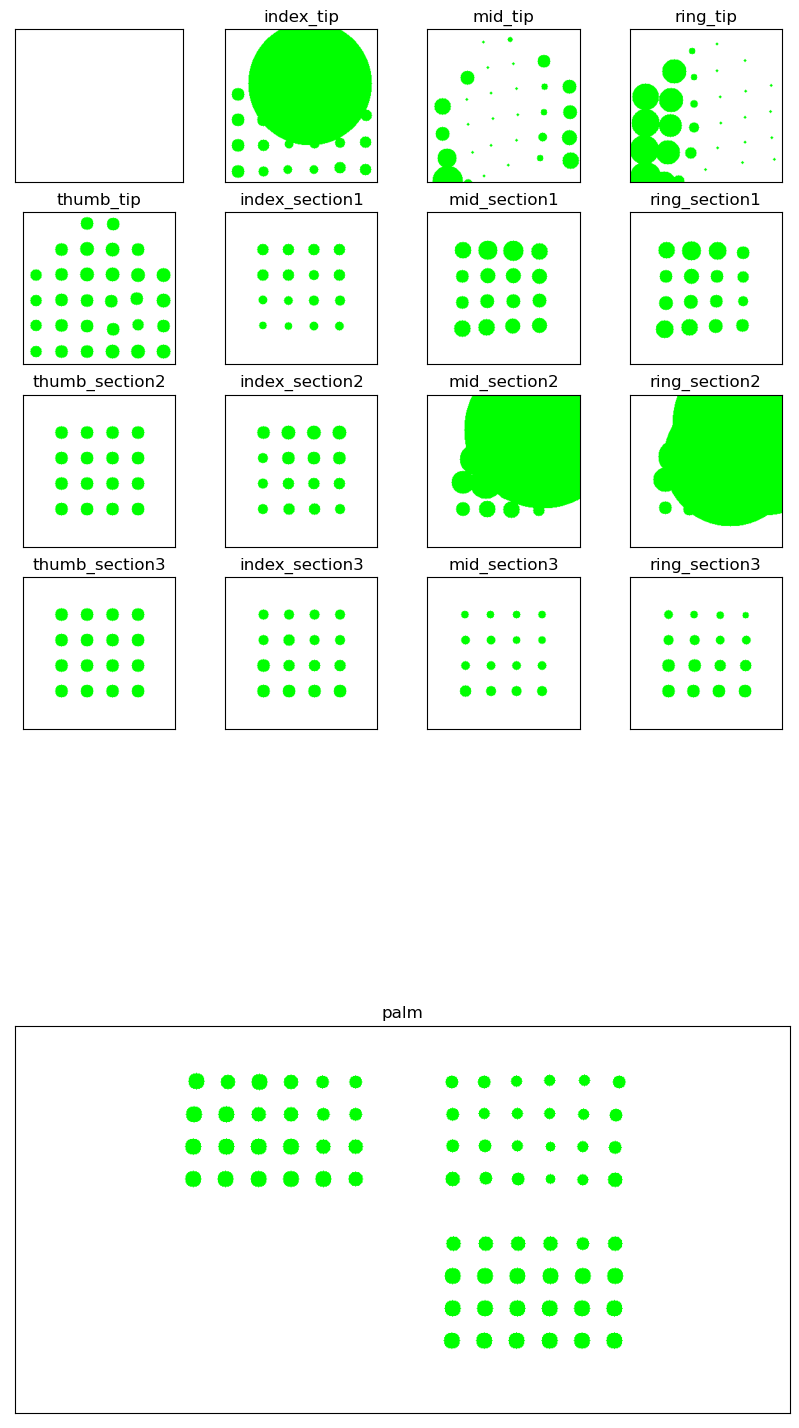

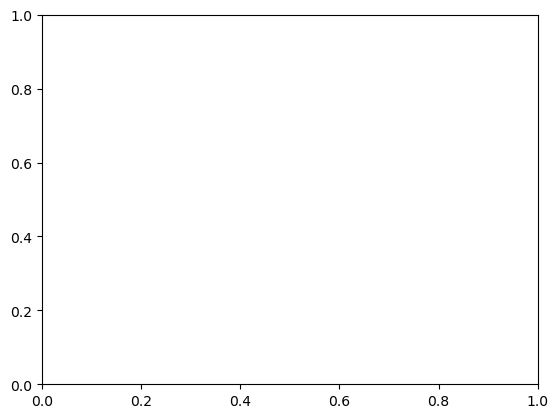

In [7]:
root = '/data/state_recognition/R1B0R/demonstration_15'
tactile_info_path = os.path.join(root, 'touch_sensor_values.h5')
with h5py.File(tactile_info_path, 'r') as f:
    tactile_timestamps = f['timestamps'][()]
    finger_values = f['finger_sensor_values'][()]
    fingertip_values = f['fingertip_sensor_values'][()]
    palm_values = f['palm_sensor_values'][()]
    print('f.keys(): {}'.format(f.keys()))
    
drawer = XelaCurvedPlotter()
ID = 34
print(f'palm_values.shape: {palm_values.shape}, fingertip_values: {fingertip_values.shape}, finger_values: {finger_values.shape}')
drawer.draw(palm_sensor_values=palm_values[ID], fingertip_sensor_values=fingertip_values[ID], finger_sensor_values=finger_values[ID], figure_plot_path='curved_sensors.png')

In [8]:
import glob
# roots = [
#     '/home/irmak/Workspace/Holo-Bot/extracted_data/bowl_picking/eval/demonstration_7',
#     '/home/irmak/Workspace/Holo-Bot/extracted_data/bowl_picking/eval/demonstration_9',
#     '/home/irmak/Workspace/Holo-Bot/extracted_data/bowl_picking/eval/demonstration_15',
# ]
data_path = '/home/irmak/Workspace/Holo-Bot/extracted_data/plier_picking'
# data_path = '/data/tactile_learning/deployment_data/data/bowl_picking/demonstrations/image_generalization'
roots = glob.glob(f'{data_path}/demonstration_*')
# roots = [f'{data_path}/demonstration_6']

roots = [
    '/data/state_recognition/R1B0R/demonstration_15',
]

retrieval_fps = 2
view_num = 1
for root in roots:
    tactile_indices, image_indices = get_desired_indices(root=root, fps=retrieval_fps, view_num=view_num)
    print('tactile_indices: {}, image_indices: {}'.format(tactile_indices, image_indices))
    dump_states_curved_fingertip(root, tactile_indices, image_indices, view_num=view_num)


tactile_indices: [0, 48, 90, 136, 183, 227, 272, 320, 365, 410, 455, 500, 545, 591, 637, 682, 729, 777, 820, 873, 913, 961, 1008, 1055, 1100, 1147, 1195, 1238, 1283, 1330, 1374, 1423, 1466, 1512, 1558, 1603, 1648, 1690, 1737, 1785, 1831, 1879, 1924, 1970, 2018, 2064, 2112, 2157, 2210, 2251, 2300, 2348, 2395, 2435, 2482, 2528, 2576, 2620, 2669, 2714, 2761, 2806, 2858, 2895, 2947, 2989, 3035, 3082, 3128, 3175, 3222, 3266, 3310, 3358, 3401, 3449, 3492, 3541, 3587, 3632, 3681, 3725, 3772, 3817, 3863, 3907, 3957, 4002, 4048, 4093, 4142, 4184, 4227, 4273, 4320, 4367, 4415, 4461, 4506, 4551, 4599, 4646, 4691], image_indices: [78, 93, 108, 123, 138, 153, 168, 183, 198, 213, 228, 243, 258, 273, 288, 303, 318, 333, 348, 363, 378, 393, 408, 423, 438, 453, 468, 483, 498, 513, 528, 543, 558, 573, 588, 603, 618, 633, 648, 663, 678, 693, 708, 723, 738, 753, 768, 783, 798, 813, 827, 842, 856, 871, 886, 901, 916, 931, 946, 961, 976, 991, 1006, 1021, 1036, 1051, 1066, 1081, 1096, 1111, 1126, 1141, 1156,

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [09:10<00:00,  5.34s/it]


In [10]:
print(roots)

['/data/state_recognition/R1B0R/demonstration_15']


In [5]:
# Turn the images to a video and delete the directory
video_fps = 10
for root in roots:
    print('dumping video in root: {}'.format(root))
    video_path = os.path.join(root, f'visualization_{view_num}.mp4')
    if os.path.exists(video_path):
        os.remove(video_path)
    viz_dir = os.path.join(root, 'visualization')
    os.system('ffmpeg -r {} -i {}/%*.png -vf scale=2000x720,setsar=1:1 {}'.format(
        video_fps, # fps
        viz_dir,
        video_path
    ))


dumping video in root: /home/irmak/Workspace/tactile-learning/deployment_data/xela_curved_sr_test/1


ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 10.4.0 (conda-forge gcc 10.4.0-18)
  configuration: --prefix=/home/irmak/miniconda3/envs/tactile_learning --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1666357487580/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1666357487580/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1666357487580/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1666357487580/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-gnutls --enable-libmp3lame --enable-libvpx --enable-pthreads --enable-vaapi --enable-gpl --enable-libx264 --enable-libx265 --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-pic --enable-shared --disable-

In [11]:
# Remove the img directory

for root in roots:
    viz_dir = os.path.join(root, 'visualization')
    shutil.rmtree(viz_dir)
